<a href="https://colab.research.google.com/github/realnihal/Forecasting-COVID-19-cases/blob/main/COVID19_forecasting_using__deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting COVID-19 Case in India with deep learning**

## Introduction

The goal of this project is to give a fair estimate of covid cases in India. I came across an published article on [Forecasting COVID-19 cases](https://reader.elsevier.com/reader/sd/pii/S2211379721000048?token=96B6C9E2813943F5D2FE4882F66A79AFA5E8779BC525996AA7E6F9EE1B924E254C50FC4994A800B07CE92EADF065D17B&originRegion=eu-west-1&originCreation=20210815022455). They were able to make predections with an error of less that 2%. Here I have tried to implement their learnings and try to make predictions for the next few days.

## Importing data

I have imported the covid-19 data from [this source](https://documenter.getpostman.com/view/10724784/SzYXXKmA). The data is collected by volunteers and pre-cleaned. We get access to various metrics but only interested in the "Daily Case" counts.



In [ ]:
# importing the Covid-19 time series data
import urllib.request
url = 'https://api.covid19india.org/csv/latest/case_time_series.csv'
filename = 'case_time_series.csv'
urllib.request.urlretrieve(url, filename)

('case_time_series.csv', <http.client.HTTPMessage at 0x7f212115dd50>)

In [ ]:
# reading the covid-19 data using pandas
import pandas as pd
df = pd.read_csv("case_time_series.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)

df.head()

,Date_YMD,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
Date,,,,,,,
2020-01-30,2020-01-30,1,1,0,0,0,0
2020-01-31,2020-01-31,0,1,0,0,0,0
2020-02-01,2020-02-01,0,1,0,0,0,0
2020-02-02,2020-02-02,1,2,0,0,0,0
2020-02-03,2020-02-03,1,3,0,0,0,0


In [ ]:
# just taking the daily covid cases.
daily_cases = pd.DataFrame(df["Daily Confirmed"]).rename(columns={"Daily Confirmed": "cases"})

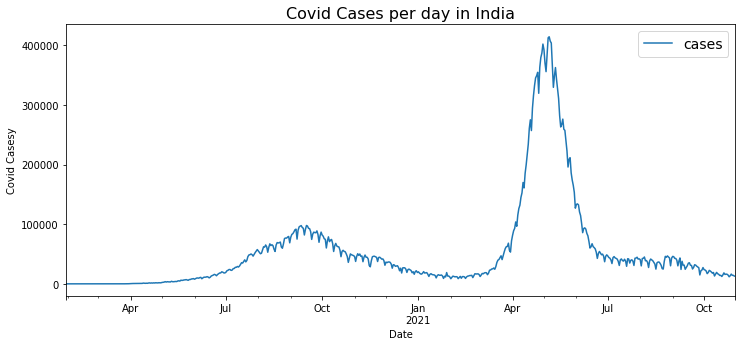

In [ ]:
# plotting the data
import matplotlib.pyplot as plt
daily_cases.plot(figsize=(12, 5))
plt.ylabel("Covid Casesy")
plt.title("Covid Cases per day in India", fontsize=16)
plt.legend(fontsize=14);
plt.show()

In [ ]:
# Normalizing the data
timesteps = daily_cases.index.to_numpy()
cases = daily_cases["cases"].to_numpy()
cases = cases/414280

In [ ]:
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30 

In [ ]:
# creating data windows
def make_windows(x, window_size=7, horizon=1):
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")
  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}"
  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
import numpy as np
full_windows, full_labels = make_windows(cases, window_size=WINDOW_SIZE, horizon=HORIZON)

In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [ ]:
import os
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) 

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Let's build an Stacked LSTM model with the Functional API

from keras.models import Model
from keras.layers import LSTM,Dense,Flatten,Dropout,Input,Lambda
inputs=Input(shape=(WINDOW_SIZE))
x=Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x=LSTM(128, activation="relu", return_sequences=True)(x)
x=Dropout(0.2)(x)
x=LSTM(128, activation="relu")(x)
x=Dropout(0.2)(x)
x=Dense(32, activation="relu")(x)
output=Dense(HORIZON)(x)
model_5=Model(inputs=inputs, outputs=output, name="model_5_lstm")

'''inputs = layers.Input(shape=(WINDOW_SIZE))
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
x = tf.keras.layers.layers.LSTM(128, activation="relu", return_sequences=True)(x) 
x = tf.keras.layers.layers.Dropout(0.2)(x)
x = tf.keras.layers.layers.LSTM(128, activation="relu")(x)
x = tf.keras.layers.layers.Dropout(0.2)(x)
x = tf.keras.layers.layers.Dense(32, activation="relu")(x)
output = tf.keras.layers.layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")'''

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.0005))

history = model_5.fit(train_windows,
            train_labels,
            epochs=150,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
# evaluating the best model
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

4/4 [==============================] - 0s 5ms/step - loss: 0.0080


0.00802721455693245

## Results

we can see that we have achieved an error of 2.7% which is slightly higher than the original [paper](https://reader.elsevier.com/reader/sd/pii/S2211379721000048?token=96B6C9E2813943F5D2FE4882F66A79AFA5E8779BC525996AA7E6F9EE1B924E254C50FC4994A800B07CE92EADF065D17B&originRegion=eu-west-1&originCreation=20210815022455). Lets try to use this model to predict the future cases.

In [ ]:
def make_preds(pcases, model):
    no_of_preds = 100
    for i in range(no_of_preds):
        eval_case = pcases[-30:].reshape(1,30)
        pred = model.predict(eval_case)
        pcases = np.append(pcases,pred)
    return pcases
pred_cases = make_preds(cases, model_5)
pred_cases[-10:]

array([0.04418889, 0.0445498 , 0.04490615, 0.04525481, 0.04560323,
       0.04596801, 0.04636215, 0.0467819 , 0.04721073, 0.04763965])

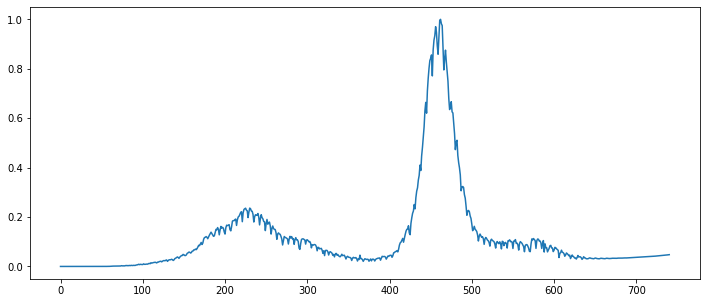

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(pred_cases)
plt.show()

We can see the rising trend of an upcoming third wave in the country. We have to consider a lot of things before we take this model seriously, such as:

1. We are using a single feature (univariate) to make the prediction. this may not be accurate as the real trends could be more correlated to  other factors.

2. The further in the future we want to predict, the less accurate the model becomes. This means that the actual slope may not be accurate. The peak or duration of the third wave might by varying a lot.

But nevertheless, this is an alarming sign that the public should be prepared. I really wish that this does'nt happen and the model is wrong, but it's still a good idea to increase precautions and try to save yoursleves.